In [1]:
import sqlite3

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import alpha_hull

In [3]:
# Lecture des zones parents :

db_filename = '../data/arbres.db'
db = sqlite3.connect(db_filename)

cursor = db.cursor()

In [4]:
# get dict of all the zones
cursor.execute(""" SELECT DISTINCT code_parent, code_parent_desc FROM arbres  """)
zones_parent = { x[0]: {'name':x[1]} for x in cursor.fetchall() }

print( len(zones_parent) )

1445


In [5]:
# add infos about trees
for code_parent, infos in zones_parent.items():
    cursor.execute("""
        SELECT genre_bota, longitude, latitude FROM arbres 
        WHERE code_parent  = ?""", (code_parent, ))

    #nametuples = cursor.fetchmany(10)
    infos['arbres'] = cursor.fetchall()

In [6]:
def get_species( arbres ):
    """ retourne la liste des espèces (genre) présentes
    """
    spec = { tree[0] for tree in arbres }
    return list(spec)

In [7]:
def get_coords_deg( arbres ):
    latlon = [ (tree[1], tree[2])  for tree in arbres ]
    return np.array( latlon )

def get_coordsarray( infos ):
    """ construit le ndarray des coordonnées en les convertissant (scale, pas de projection sphèrique)
        en mètre
        retourne l'array (n_points, n_dim), et la fonction de scaling inverse
    """
    points_deg = get_coords_deg( infos['arbres'] )
    center_deg = points_deg.mean( axis = 0 )

    R_Earth =  6371008  # m
    scale_factor = np.pi/180*R_Earth

    points_m = (points_deg - center_deg)*scale_factor
    scale_back = lambda X: X/scale_factor + center_deg
    
    return points_m, scale_back

In [8]:
# Pick one :
code_parent, infos = list( zones_parent.items() )[17]
print( infos['name'], len(infos['arbres']), get_species(infos['arbres'])  )

Tr quartiers gymn de la rampe 31 ['Acer', 'Sorbus', 'Alnus', 'Fraxinus', 'Pinus', 'Carpinus']


In [9]:
points_m, scale_back = get_coordsarray( infos )

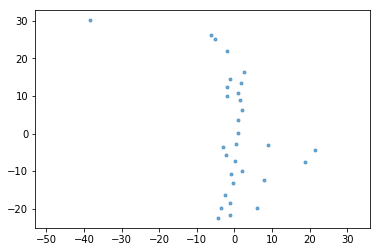

In [10]:
plt.plot( *points_m.T, '.', alpha=.6 )
plt.axis('equal');

In [11]:
def add_contourpoints( points_list,  n_points = 5, r_cercle = 3 ):
    """ Ajoute des points virtuels autour des arbres pour donner
        une épaisseur au polygone dans le cas où les arbres sont 
        tous alignés
        
        n_point: nombre de points à ajouter
        r_cercle: distance au centre 
    """

    thetas = np.linspace( 0, 2*np.pi, n_points+1 )[:-1]

    added_point = []
    for x, y in points_list:

        x_add = x + r_cercle * np.cos( thetas )
        y_add = y + r_cercle * np.sin( thetas )

        added_point.extend( zip( x_add, y_add ) )
    
    return np.array( added_point )

In [12]:
added_points = add_contourpoints( points_m )

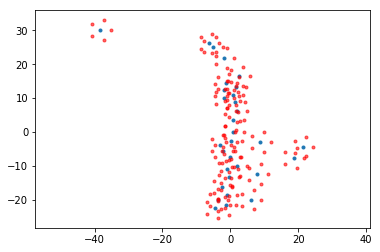

In [13]:
plt.plot( *points_m.T, '.' )
plt.axis('equal');

plt.plot( *added_points.T, '.r', alpha=.6 )
plt.axis('equal');

In [14]:
# - Alpha hub - 
all_points = np.concatenate( (added_points, points_m) )

Rcritic = 12  # m
polygon = alpha_hull.alpha_shape( all_points, Rcritic  )[0]

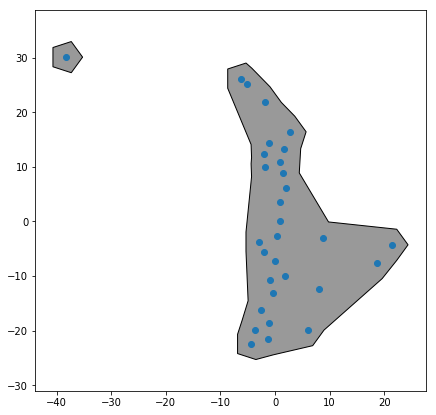

In [15]:
# plot
alpha_hull.plot_polygon( polygon  )
plt.plot( *points_m.T, 'o' )
plt.axis('equal');

In [16]:
# Rq: Delaunay ne marche pas avec les coords en degrée dec. ... 

In [17]:
import geojson as gj
# https://pypi.python.org/pypi/geojson#polygon

In [18]:
def get_geom( polygon, scale_back ):
    """ retourne la partie Geométrie du GeoJson pour l'objet polygon
        peut être un simple ou MultiPolygon
        - convertie les coords en degrée décimaux avec la fonction scale_back
    """
    
    if polygon.geom_type == 'MultiPolygon':
        
        all_coords = []
        for part in polygon.boundary:
            boundary_coords = part.coords
            boundary_coords = scale_back( np.array(boundary_coords) ).tolist()
            all_coords.append( (boundary_coords, )  ) # supplementary tuple ??

        geom = gj.MultiPolygon( all_coords )

    elif polygon.geom_type == 'Polygon':
        boundary_coords = polygon.boundary.coords
        boundary_coords = scale_back( np.array(boundary_coords) ).tolist()
        geom = gj.Polygon( boundary_coords )
        
    return geom

In [19]:
geom = get_geom( polygon, scale_back )
featprops = {'code_parent':code_parent , 'code_parent_desc':infos['name'], 'genre':get_species(infos['arbres'])}
feat = gj.Feature(geometry=geom, properties=featprops ) 

In [20]:
feat

{"geometry": {"coordinates": [[[[5.732914456451269, 45.1626508437346], [5.73289581399629, 45.162625184596614], [5.7328656498705, 45.162634985515204], [5.7328656498705, 45.162666701954], [5.73289581399629, 45.16267650287259], [5.732914456451269, 45.1626508437346]]], [[[5.733228663109791, 45.16216051624931], [5.733199900480351, 45.16215277211461], [5.733169736354561, 45.1621625730332], [5.733169736354561, 45.162194289472], [5.73317712568592, 45.162216964288], [5.73318711699437, 45.1622495777551], [5.73318360500254, 45.1623309860654], [5.73318360500254, 45.1623627025042], [5.73319278886438, 45.1624537547318], [5.73319201981431, 45.1624752370972], [5.73319278886438, 45.1624854711706], [5.73319201981431, 45.162506953535996], [5.73315350754147, 45.162599596072305], [5.73315350754147, 45.1626313125111], [5.73318367166726, 45.16264111342969], [5.7331932806256605, 45.16263256520589], [5.73322317764853, 45.16260196530499], [5.733241820103509, 45.162576306167], [5.73326398323087, 45.1625535429962